### Basic test of classification with the new features

##### Here we investiage whether adding more features is helpful. We find that there is probably an optimal number of features to train on
##### which implies that we should do PCA

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
import DataProcess as DP
import glob
import time
import pandas as pd
from plotting_tools import plot_feature_distributions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
protocol_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/'
optional_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Optional/'

In [43]:
allfiles = list(glob.glob(protocol_datadir+'*.dat'))+list(glob.glob(optional_datadir+'*.dat'))
allfiles = list(glob.glob(protocol_datadir+'*.dat'))

all_dfs = []
for fname in allfiles:
    print(fname)
    dp = DP.dataprocess(fname,T=512,stride=512)
    all_dfs.append(dp.df)
    
feature_df = pd.concat(all_dfs)

/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject101.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject102.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject103.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject104.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject105.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject106.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject107.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject108.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject109.dat


In [95]:
feature_df.to_csv('Features_test.dat',index=False)

### Figure out the number of segments associated with each activity

In [45]:
activity_list = ['lying','sitting','standing','walking','running','cycling','nordic walking','watching TV',
                 'computer work','car driving','ascending stairs','descending stairs',
                  'vacuum cleaning','ironing','folding laundry','house cleaning','playing_soccer','rope jumping']
#activities = pd.get_dummies(feature_df['activityID'],drop_first=True)
activities = feature_df['activityID']
activities = feature_df['activityID'].astype("category")

In [46]:
activities.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: activityID, dtype: category
Categories (12, float64): [1.0, 2.0, 3.0, 4.0, ..., 13.0, 16.0, 17.0, 24.0]

In [47]:
X = feature_df.drop(['activityID'],axis=1)

#### Train a random forest and looking at the feature importances

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,activities,test_size=0.3)

In [49]:
RF = RandomForestClassifier(n_estimators=50,min_samples_split=2,min_samples_leaf=1,max_depth=12,oob_score=True)
#note the max_features criterion here - setting this between 50 and 100 makes a small improvment to the results 

In [50]:
RF = RandomForestClassifier(n_estimators=105,min_samples_leaf=1,max_depth=20,oob_score=True,class_weight='balanced_subsample',
                           criterion='gini')

In [51]:
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=105, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [52]:
RF.oob_score_

0.990990990990991

In [53]:
#list the most important features and their importance values
importances = RF.feature_importances_
args = np.flip(np.argsort(importances),axis=0)

In [54]:
features_to_keep = []
for i in range(len(args)):
    arg = args[i]
    print('Feature %s. Importance: %f' %(X_train.columns[arg],importances[arg]))
    features_to_keep.append(X_train.columns[arg])

Feature chest_acc16g_y_std. Importance: 0.032306
Feature ankle_acc16g_x_median. Importance: 0.025757
Feature ankle_gyro_z_std. Importance: 0.024968
Feature ankle_acc16g_x_mean. Importance: 0.024791
Feature hand_acc16g_y_std. Importance: 0.024321
Feature ankle_acc16g_x_std. Importance: 0.023789
Feature chest_acc16g_y_peak. Importance: 0.022118
Feature chest_gyro_y_std. Importance: 0.019023
Feature chest_acc_spectrum_energy. Importance: 0.018792
Feature chest_gyro_y_mean. Importance: 0.017908
Feature chest_acc16g_z_mean. Importance: 0.017560
Feature chest_gyro_spectrum_energy. Importance: 0.017355
Feature chest_acc16g_z_median. Importance: 0.017344
Feature ankle_gyro_spectrum_energy. Importance: 0.017336
Feature hand_acc_spectrum_energy. Importance: 0.017042
Feature ankle_acc_spectrum_energy. Importance: 0.016954
Feature hand_acc16g_x_median. Importance: 0.016807
Feature ankle_gyro_x_mean. Importance: 0.015691
Feature ankle_acc16g_y_std. Importance: 0.014465
Feature chest_acc16g_x_std. I

In [55]:
RF.score(X_test,y_test)

0.98998998998999

Interestingly we seem to be doing worse with all these features. This suggests that we might be overfitting and need to reduce the number of features. Lets try to see if there is an optimal number of features for our test score

In [56]:
def investigate_feature_numbers(X,Y,classifier,step_features=2,min_features=5):
    
    '''
    Train the algorithm on datasets containing decreasing numbers of features in order to
    determine if there is an optimal number of features
    '''
    
    #Start by training a random forest
    
    print("Training on all features")
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)
    classifier.fit(X_train,y_train)
    
    train_scores = [classifier.score(X_train,y_train)]
    test_scores  = [classifier.score(X_test,y_test)]
    feature_number_list = [len(X_train.columns)]
    
    #Extract just the first n features to train on. We'll extract the features in order of importance
    #to try to ensure that we get 
    
    importances = RF.feature_importances_
    args = np.flip(np.argsort(importances),axis=0)
    features_to_keep = []
    for i in range(len(X_train.columns)-step_features):
        arg = args[i]
        features_to_keep.append(X_train.columns[arg])
        
    for feature_number in np.arange(len(X.columns)-step_features,min_features,-step_features):
         
        X_new = X[features_to_keep]
        
        print(len(features_to_keep))
        
        print("Training on %i features" %feature_number)
        
        X_train, X_test, y_train, y_test = train_test_split(X_new,Y,test_size=0.3)
        classifier.fit(X_train,y_train)
        train_scores.append(classifier.score(X_train,y_train))
        test_scores.append(classifier.score(X_test,y_test))
        feature_number_list.append(len(X_new.columns))
        
        importances = classifier.feature_importances_
        args = np.flip(np.argsort(importances),axis=0)
        features_to_keep = []
        for i in range(feature_number-step_features):
            arg = args[i]
            features_to_keep.append(X_train.columns[arg])
            
        if len(features_to_keep) <= min_features:
            return test_scores, train_scores, feature_number_list
        
        

In [57]:
test_scores, train_scores, feature_numbers = investigate_feature_numbers(X,activities,RF)

Training on all features
195
Training on 195 features
193
Training on 193 features
191
Training on 191 features
189
Training on 189 features
187
Training on 187 features
185
Training on 185 features
183
Training on 183 features
181
Training on 181 features
179
Training on 179 features
177
Training on 177 features
175
Training on 175 features
173
Training on 173 features
171
Training on 171 features
169
Training on 169 features
167
Training on 167 features
165
Training on 165 features
163
Training on 163 features
161
Training on 161 features
159
Training on 159 features
157
Training on 157 features
155
Training on 155 features
153
Training on 153 features
151
Training on 151 features
149
Training on 149 features
147
Training on 147 features
145
Training on 145 features
143
Training on 143 features
141
Training on 141 features
139
Training on 139 features
137
Training on 137 features
135
Training on 135 features
133
Training on 133 features
131
Training on 131 features
129
Training on 12

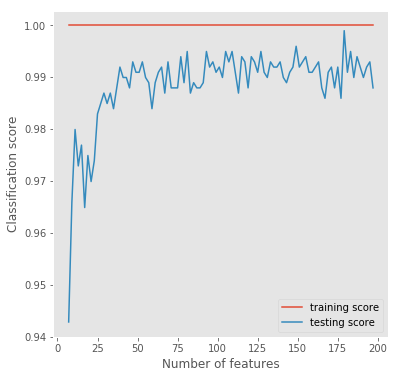

In [58]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(6,6))
plt.plot(feature_numbers,train_scores,label='training score')
plt.plot(feature_numbers,test_scores,label='testing score')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Classification score')
plt.grid(axis='both')

#### Since it seems like ~75 features is optimal, lets try a PCA here

In [178]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


##### We can choose to scale the input data, but it does not make a dramatic change to the results

In [179]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

##### Use PCA to transform the data

In [223]:
pca = PCA(n_components=9)
pca.fit(X)
X_pca = pca.transform(X)

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,activities,test_size=0.3)
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [225]:
RF.oob_score_

0.9861167320652461

In [226]:
RF.score(X_test,y_test)

0.8172942817294282

#### Its quite odd that the RF performs well on a PCA dataset with only a small number of components. Increasing the number of components reduces the fit

In [2]:
feature_df['activityID'].unique()

NameError: name 'feature_df' is not defined